<a href="https://colab.research.google.com/github/idax6797/DeepLearning-MiniProject/blob/main/Notebooks/TransUnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tumor Segmnetation in PET-MPT Images using TransUnet

In [4]:
!git status


fatal: not a git repository (or any of the parent directories): .git


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from pathlib import Path
from typing import Tuple, List
import cv2
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


# DataLoader

In [ ]:
class TumorSegmentationDataset(Dataset):
    def __init__(self, data_dir:str, transform=None, image_size=(256, 256)):
        self.data_dir = data_dir
        self.transform = transform
        self.image_size = image_size

        self.image_dir = os.path.join(data_dir, 'patients/imgs')
        self.mask_dir = os.path.join(data_dir, 'patients/labels')
        self.control_dir = os.path.join(data_dir, 'controls/imgs')

        self.image_files = sorted([f for f in os.listdir(self.image_dir) if f.endswith('.png')])
        self.control_files = sorted([f for f in os.listdir(self.control_dir) if f.endswith('.png')])

        self.samples = []

        for img_file in self.image_files:
            img_path = os.path.join(self.image_dir, img_file)
            mask_file = img_file.replace('patient_', 'segmentation_')
            mask_path = os.path.join(self.mask_dir, mask_file)
            self.samples.append((img_path, mask_path, False))

        for img_file in self.control_files:
            img_path = os.path.join(self.control_dir, img_file)
            self.samples.append((img_path, None, True))

        print(f"Total samples: {len(self.samples)} (Patients: {len(self.image_files)}, Controls: {len(self.control_files)})")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path, is_control = self.samples[idx]


        image = Image.open(img_path).convert('L')
        image = image.resize(self.image_size, Image.BILINEAR)
        image = np.array(image).astype(np.float32)

        if image.max() > 1:
            image = image / 255.0

        if mask_path and os.path.exists(mask_path):
            mask = Image.open(mask_path).convert('L')
            mask = mask.resize(self.image_size, Image.NEAREST)
            mask = np.array(mask).astype(np.float32)
            mask = (mask > 0.5).astype(np.float32)
        else:
            mask = np.zeros_like(image)

        #print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")

        if len(image.shape) == 2:
            image = np.expand_dims(image, axis=0)

        if len(mask.shape) == 2:
            mask = np.expand_dims(mask, axis=0)

        #Convert to tensors
        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask)

        if self.transform:
            state = torch.get_rng_state()
            image = self.transform(image)
            torch.set_rng_state(state)
            mask = self.transform(mask)

        return image, mask

In [ ]:
train_dataset = TumorSegmentationDataset(data_dir='/content/drive/MyDrive/Deep Learning Mini Project Tumor Images/data')
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

print(f"DataLoader ready: {len(train_loader)} batches per epoch.")

Total samples: 608 (Patients: 182, Controls: 426)
DataLoader ready: 76 batches per epoch.


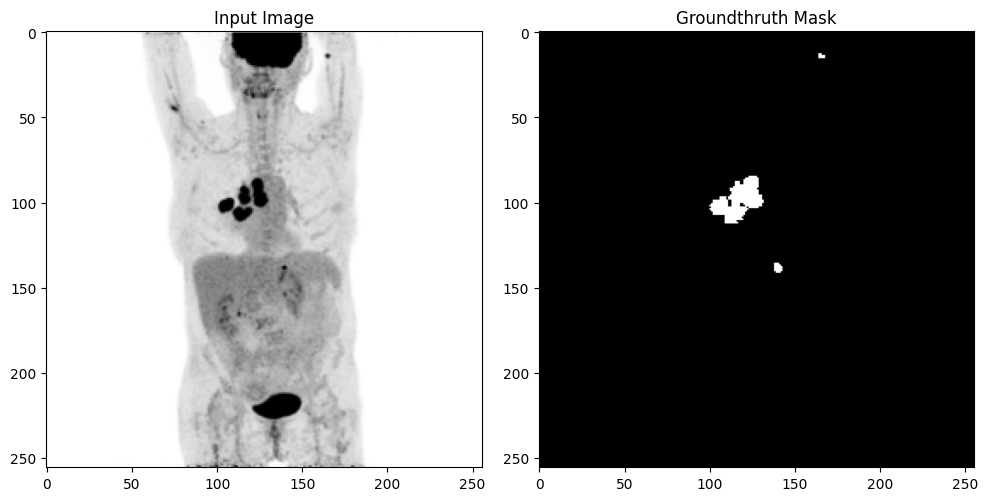

In [ ]:
# Display Random image and label.
train_features, train_labels = next(iter(train_loader))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(train_features[0].squeeze(), cmap="gray")
ax1.set_title('Input Image')
ax2.imshow(train_labels[0].squeeze(), cmap="gray")
ax2.set_title('Groundthruth Mask')
plt.tight_layout()
plt.show()

# TransUnet Architecture

In [ ]:
class PatchEmbedding(nn.Module):
    """Split image into patches and embed them"""

    def __init__(self, img_size=256, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        self.proj = nn.Conv2d(in_channels, embed_dim,
                             kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/P, W/P)
        x = x.flatten(2)  # (B, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (B, n_patches, embed_dim)
        return x

In [ ]:
class MultiHeadAttention(nn.Module):
    """Multi-head self-attention mechanism"""

    def __init__(self, embed_dim=768, num_heads=12, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, C = x.shape

        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        attn = attn.softmax(dim=-1)
        attn = self.dropout(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.dropout(x)

        return x

In [ ]:
class TransformerBlock(nn.Module):
    """Transformer encoder block"""

    def __init__(self, embed_dim=768, num_heads=12, mlp_ratio=4, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)

        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

In [ ]:
class CNNEncoder(nn.Module):
    """CNN encoder for grayscale images"""

    def __init__(self, in_channels=1):
        super().__init__()

        # Custom encoder for grayscale images
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.conv2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.conv3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.conv4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        features = []
        x = self.conv1(x)  # (B, 64, H/2, W/2)
        features.append(x)

        x = self.conv2(x)  # (B, 256, H/4, W/4)
        features.append(x)

        x = self.conv3(x)  # (B, 512, H/8, W/8)
        features.append(x)

        x = self.conv4(x)  # (B, 1024, H/16, W/16)
        features.append(x)

        return features

In [ ]:
class DecoderBlock(nn.Module):
    """Decoder block with skip connections"""

    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels,
                                        kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            nn.Conv2d(out_channels + skip_channels, out_channels,
                     kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, skip):
        x = self.upconv(x)
        x = torch.cat([x, skip], dim=1)
        x = self.conv(x)
        return x

In [ ]:
class TransUNet(nn.Module):
    """TransUNet architecture for medical image segmentation"""

    def __init__(self, img_size=256, patch_size=16, in_channels=1,
                 num_classes=1, embed_dim=768, num_heads=12,
                 num_layers=12, mlp_ratio=4, dropout=0.1):
        super().__init__()

        # Validate that embed_dim is divisible by num_heads
        assert embed_dim % num_heads == 0, f"embed_dim ({embed_dim}) must be divisible by num_heads ({num_heads})"

        # CNN Encoder
        self.cnn_encoder = CNNEncoder(in_channels=in_channels)

        # Patch embedding
        self.patch_embed = PatchEmbedding(
            img_size=img_size//16, patch_size=1,
            in_channels=1024, embed_dim=embed_dim
        )

        # Transformer encoder
        self.transformer = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(num_layers)
        ])

        self.norm = nn.LayerNorm(embed_dim)

        # Bridge to decoder
        self.conv_bridge = nn.Conv2d(embed_dim, 512, kernel_size=1)

        # Decoder
        self.decoder4 = DecoderBlock(512, 512, 256)
        self.decoder3 = DecoderBlock(256, 256, 128)
        self.decoder2 = DecoderBlock(128, 64, 64)
        self.decoder1 = DecoderBlock(64, 64, 32)
        # Upsample to original size
        self.final_upsample = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        # Final output
        self.final = nn.Sequential(
            nn.Conv2d(64, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, num_classes, kernel_size=1)
        )

    def forward(self, x):
        # CNN encoder
        features = self.cnn_encoder(x)

        # Transformer encoder
        x_transformer = self.patch_embed(features[3])
        for block in self.transformer:
            x_transformer = block(x_transformer)
        x_transformer = self.norm(x_transformer)

        # Reshape transformer output
        B, N, C = x_transformer.shape
        H = W = int(N ** 0.5)
        x_transformer = x_transformer.transpose(1, 2).reshape(B, C, H, W)
        x_transformer = self.conv_bridge(x_transformer)

        # Decoder with skip connections
        x = self.decoder4(x_transformer, features[2]) # (16x16) -> (32x32) + features[2]
        x = self.decoder3(x, features[1]) # (32x32) -> (64x64) + features[1](64x64)
        x = self.decoder2(x, features[0]) # (64x64) -> (128x128) + features[0](128x128)

        # Upsample to original size
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)

        # Final output
        x = self.final(x)

        return x

# Metrics and Loss Functions


In [ ]:
def dice_coefficient(pred, target, smooth=1e-5):
    """Calculate Dice coefficient"""
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()

    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))

    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()


In [ ]:
def calculate_metrics(pred, target, smooth=1e-5):
    """Calculate TP, TN, FP, FN, IoU"""
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    target = target.float()

    # Flatten
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)

    # Calculate confusion matrix components
    TP = ((pred_flat == 1) & (target_flat == 1)).sum().item()
    TN = ((pred_flat == 0) & (target_flat == 0)).sum().item()
    FP = ((pred_flat == 1) & (target_flat == 0)).sum().item()
    FN = ((pred_flat == 0) & (target_flat == 1)).sum().item()

    # Calculate IoU (Intersection over Union)
    intersection = (pred * target).sum().item()
    union = pred.sum().item() + target.sum().item() - intersection
    iou = (intersection + smooth) / (union + smooth)

    return {
        'TP': TP,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'IoU': iou,
        'Precision': TP / (TP + FP + smooth),
        'Recall': TP / (TP + FN + smooth),
        'F1': 2 * TP / (2 * TP + FP + FN + smooth)
    }

In [ ]:
class DiceLoss(nn.Module):
    """Dice loss for segmentation"""

    def __init__(self, smooth=1e-5):
        super().__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)

        intersection = (pred * target).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))

        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

In [ ]:
class CombinedLoss(nn.Module):
    """Combined BCE and Dice loss"""

    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super().__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self, pred, target):
        bce_loss = self.bce(pred, target)
        dice_loss = self.dice(pred, target)
        return self.bce_weight * bce_loss + self.dice_weight * dice_loss

# Training Function


In [ ]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    total_dice = 0

    pbar = tqdm(train_loader, desc="Training")
    for images, masks in pbar:
        images = images.to(device)
        masks = masks.to(device)

        #Forward pass
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, masks)
        dice = dice_coefficient(outputs, masks)

        #Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_dice += dice.item()

        pbar.set_postfix({
            "Loss": f'{loss.item():.4f}',
            "Dice": f'{dice.item():.4f}'
        })

    avg_loss = total_loss / len(train_loader)
    avg_dice = total_dice / len(train_loader)

    return avg_loss, avg_dice

In [ ]:
def validate(model, val_loader, criterion, device):
    """Validate the model"""
    model.eval()
    total_loss = 0
    total_dice = 0
    all_metrics = {
        'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0,
        'IoU': 0, 'Precision': 0, 'Recall': 0, 'F1': 0
    }

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc='Validation'):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)

            loss = criterion(outputs, masks)
            dice = dice_coefficient(outputs, masks)
            metrics = calculate_metrics(outputs, masks)

            total_loss += loss.item()
            total_dice += dice.item()

            for key in all_metrics:
                all_metrics[key] += metrics[key]

    avg_loss = total_loss / len(val_loader)
    avg_dice = total_dice / len(val_loader)

    for key in all_metrics:
        all_metrics[key] /= len(val_loader)

    return avg_loss, avg_dice, all_metrics

In [ ]:
def plot_training_history(train_losses, train_dices, val_losses, val_dices):
    """Plot training history"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    axes[0].plot(train_losses, label='Train Loss')
    if val_losses:
        axes[0].plot(val_losses, label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Dice plot
    axes[1].plot(train_dices, label='Train Dice')
    if val_dices:
        axes[1].plot(val_dices, label='Val Dice')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Dice Score')
    axes[1].set_title('Training and Validation Dice Score')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=50,
                learning_rate=1e-4, save_dir='checkpoints'):
    """Complete training pipeline"""

    os.makedirs(save_dir, exist_ok=True)

    criterion = CombinedLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    best_dice = 0.0
    train_losses, train_dices = [], []
    val_losses, val_dices = [], []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 50)

        # Train
        train_loss, train_dice = train_epoch(
            model, train_loader, optimizer, criterion, device
        )
        train_losses.append(train_loss)
        train_dices.append(train_dice)

        print(f'Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}')

        # Validate
        if val_loader:
            val_loss, val_dice, metrics = validate(
                model, val_loader, criterion, device
            )
            val_losses.append(val_loss)
            val_dices.append(val_dice)

            print(f'Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}')
            print(f'Val IoU: {metrics["IoU"]:.4f}')
            print(f'TP: {metrics["TP"]:.0f}, TN: {metrics["TN"]:.0f}, '
                  f'FP: {metrics["FP"]:.0f}, FN: {metrics["FN"]:.0f}')

            # Save best model based on Dice score
            if val_dice > best_dice:
                best_dice = val_dice
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'dice_score': best_dice,
                    'metrics': metrics
                }, os.path.join(save_dir, 'best_model.pth'))
                print(f'✓ Best model saved with Dice: {best_dice:.4f}')

    # Plot training history
    plot_training_history(train_losses, train_dices, val_losses, val_dices)

    return model, best_dice

# Visualization Function

In [ ]:
def visualize_predictions_CM(model, data_loader, device, num_samples=5, save_path='predictions.png'):
    """Visualize predictions: original image, ground truth, and prediction,
    and calculate Image-Level Confusion Matrix for the visualized samples."""
    model.eval()

    # --- 1. Initialize Image-Level Confusion Matrix Counters ---
    total_TP = 0
    total_TN = 0
    total_FP = 0
    total_FN = 0

    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    sample_count = 0
    with torch.no_grad():
        for images, masks in data_loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs)

            for i in range(len(images)):
                if sample_count >= num_samples:
                    break

                # --- A. Prepare Data for Visualization and Metrics ---

                # Original image (numpy)
                img = images[i].cpu().squeeze().numpy()

                # Ground truth mask (numpy)
                mask = masks[i].cpu().squeeze().numpy()

                # Predicted mask (binarized numpy)
                pred = (preds[i].cpu().squeeze().numpy() > 0.5).astype(np.float32)

                # Calculate Dice for display title
                dice = dice_coefficient(preds[i:i+1], masks[i:i+1].to(device)).item()


                # --- B. Image-Level Classification Logic ---

                # Image-Level Ground Truth: True if any pixel in mask is 1
                is_positive_truth = np.any(mask)

                # Image-Level Prediction: True if any pixel in prediction is 1
                is_positive_pred = np.any(pred)

                # Update Confusion Matrix Counters and determine title suffix
                if is_positive_truth and is_positive_pred:
                    total_TP += 1
                    title_suffix = f'TP (Dice: {dice:.3f})'
                elif not is_positive_truth and not is_positive_pred:
                    total_TN += 1
                    title_suffix = f'TN'
                elif not is_positive_truth and is_positive_pred:
                    total_FP += 1
                    title_suffix = f'FP'
                elif is_positive_truth and not is_positive_pred:
                    total_FN += 1
                    title_suffix = f'FN (Dice: {dice:.3f})'
                else:
                    title_suffix = 'Error'


                # --- C. Plotting ---

                # Col 1: Input Image
                axes[sample_count, 0].imshow(img, cmap='gray')
                axes[sample_count, 0].set_title('Input Image')
                axes[sample_count, 0].axis('off')

                # Col 2: Ground Truth
                axes[sample_count, 1].imshow(mask, cmap='gray')
                axes[sample_count, 1].set_title('Ground Truth')
                axes[sample_count, 1].axis('off')

                # Col 3: Prediction
                axes[sample_count, 2].imshow(pred, cmap='gray', vmin=0, vmax=1)
                axes[sample_count, 2].set_title(f'Prediction: {title_suffix}')
                axes[sample_count, 2].axis('off')

                sample_count += 1

            if sample_count >= num_samples:
                break

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

    # --- 2. Print Image-Level Confusion Matrix for the Visualized Samples ---
    num_visualized = total_TP + total_TN + total_FP + total_FN

    if num_visualized > 0:
        accuracy = (total_TP + total_TN) / num_visualized
        # Use a small epsilon for division safety
        precision = total_TP / (total_TP + total_FP + 1e-8)
        recall = total_TP / (total_TP + total_FN + 1e-8)

        print(f"\nImage-Level Confusion Matrix for {num_visualized} Visualized Samples:")
        print("---------------------------------------------------------")
        print(f"Total Samples: {num_visualized}")
        print(f"True Positive (TP): {total_TP} | False Positive (FP): {total_FP}")
        print(f"False Negative (FN): {total_FN} | True Negative (TN): {total_TN}")
        print("---------------------------------------------------------")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")

    print(f"Saved visualization plot to {save_path}")

In [ ]:
def visualize_predictions(model, data_loader, device, num_samples=5, save_path='predictions.png'):
    """Visualize predictions: original image, ground truth, and prediction"""
    model.eval()

    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    sample_count = 0
    with torch.no_grad():
        for images, masks in data_loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs)

            for i in range(len(images)):
                if sample_count >= num_samples:
                    break

                # Original image (grayscale)
                img = images[i].cpu().squeeze().numpy()
                axes[sample_count, 0].imshow(img, cmap='gray')
                axes[sample_count, 0].set_title('Input Image')
                axes[sample_count, 0].axis('off')

                # Ground truth
                mask = masks[i].cpu().squeeze().numpy()
                axes[sample_count, 1].imshow(mask, cmap='gray')
                axes[sample_count, 1].set_title('Ground Truth')
                axes[sample_count, 1].axis('off')

                # Prediction
                pred = (preds[i].cpu().squeeze().numpy() > 0.5).astype(np.float32)
                axes[sample_count, 2].imshow(pred, cmap='gray', vmin=0, vmax=1)
                dice = dice_coefficient(preds[i:i+1], masks[i:i+1].to(device)).item()
                if(pred.all() == 0):
                  axes[sample_count, 2].set_title(f'No Tumor')
                else:
                   axes[sample_count, 2].set_title(f'Prediction (Dice: {dice:.3f})')
                axes[sample_count, 2].axis('off')

                sample_count += 1

            if sample_count >= num_samples:
                break

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved to {save_path}")

In [ ]:
model = TransUNet(
    img_size=256,
    patch_size=16,
    in_channels=1,
    num_classes=1,
    embed_dim=768,
    num_heads=12,
    num_layers=12,
).to(device)

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

Total parameters: 108,156,081


In [ ]:
#Split data to train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


3. Starting training...

Epoch 1/20
--------------------------------------------------


Training: 100%|██████████| 61/61 [00:39<00:00,  1.56it/s, Loss=0.7807, Dice=0.0163]


Train Loss: 0.7858, Train Dice: 0.0189


Validation: 100%|██████████| 16/16 [00:03<00:00,  4.05it/s]


Val Loss: 0.7792, Val Dice: 0.0265
Val IoU: 0.0156
TP: 2666, TN: 332669, FP: 164376, FN: 1
✓ Best model saved with Dice: 0.0265

Epoch 2/20
--------------------------------------------------


Training: 100%|██████████| 61/61 [00:39<00:00,  1.53it/s, Loss=0.7755, Dice=0.0000]


Train Loss: 0.7758, Train Dice: 0.0220


Validation: 100%|██████████| 16/16 [00:04<00:00,  3.93it/s]


Val Loss: 0.7699, Val Dice: 0.0414
Val IoU: 0.0314
TP: 2544, TN: 426217, FP: 70828, FN: 122
✓ Best model saved with Dice: 0.0414

Epoch 3/20
--------------------------------------------------


Training: 100%|██████████| 61/61 [00:41<00:00,  1.49it/s, Loss=0.7551, Dice=0.1792]


Train Loss: 0.7682, Train Dice: 0.0423


Validation: 100%|██████████| 16/16 [00:04<00:00,  3.95it/s]


Val Loss: 0.7646, Val Dice: 0.0506
Val IoU: 0.0427
TP: 2624, TN: 445576, FP: 51469, FN: 43
✓ Best model saved with Dice: 0.0506

Epoch 4/20
--------------------------------------------------


Training: 100%|██████████| 61/61 [00:40<00:00,  1.50it/s, Loss=0.7493, Dice=0.1946]


Train Loss: 0.7609, Train Dice: 0.0736


Validation: 100%|██████████| 16/16 [00:04<00:00,  3.90it/s]


Val Loss: 0.7556, Val Dice: 0.0928
Val IoU: 0.0955
TP: 2450, TN: 479629, FP: 17417, FN: 216
✓ Best model saved with Dice: 0.0928

Epoch 5/20
--------------------------------------------------


Training: 100%|██████████| 61/61 [00:40<00:00,  1.50it/s, Loss=0.7509, Dice=0.1255]


Train Loss: 0.7540, Train Dice: 0.0998


Validation: 100%|██████████| 16/16 [00:04<00:00,  3.90it/s]


Val Loss: 0.7480, Val Dice: 0.1177
Val IoU: 0.1542
TP: 2026, TN: 490221, FP: 6825, FN: 641
✓ Best model saved with Dice: 0.1177

Epoch 6/20
--------------------------------------------------


Training: 100%|██████████| 61/61 [00:40<00:00,  1.50it/s, Loss=0.7458, Dice=0.1453]


Train Loss: 0.7473, Train Dice: 0.1143


Validation: 100%|██████████| 16/16 [00:04<00:00,  3.67it/s]


Val Loss: 0.7403, Val Dice: 0.0911
Val IoU: 0.1473
TP: 1170, TN: 494549, FP: 2496, FN: 1497

Epoch 7/20
--------------------------------------------------


Training: 100%|██████████| 61/61 [00:41<00:00,  1.49it/s, Loss=0.7330, Dice=0.1163]


Train Loss: 0.7383, Train Dice: 0.1508


Validation: 100%|██████████| 16/16 [00:04<00:00,  3.96it/s]


Val Loss: 0.7346, Val Dice: 0.1174
Val IoU: 0.1317
TP: 2425, TN: 485990, FP: 11056, FN: 241

Epoch 8/20
--------------------------------------------------


Training: 100%|██████████| 61/61 [00:41<00:00,  1.49it/s, Loss=0.7227, Dice=0.3932]


Train Loss: 0.7295, Train Dice: 0.2968


Validation: 100%|██████████| 16/16 [00:04<00:00,  3.78it/s]


Val Loss: 0.7256, Val Dice: 0.4142
Val IoU: 0.2336
TP: 724, TN: 496639, FP: 407, FN: 1942
✓ Best model saved with Dice: 0.4142

Epoch 9/20
--------------------------------------------------


Training: 100%|██████████| 61/61 [00:40<00:00,  1.49it/s, Loss=0.7226, Dice=0.3274]


Train Loss: 0.7229, Train Dice: 0.2539


Validation: 100%|██████████| 16/16 [00:04<00:00,  3.75it/s]


Val Loss: 0.7181, Val Dice: 0.1353
Val IoU: 0.2101
TP: 1714, TN: 493783, FP: 3262, FN: 952

Epoch 10/20
--------------------------------------------------


Training: 100%|██████████| 61/61 [00:41<00:00,  1.48it/s, Loss=0.7190, Dice=0.1667]


Train Loss: 0.7169, Train Dice: 0.2710


Validation: 100%|██████████| 16/16 [00:04<00:00,  3.94it/s]


Val Loss: 0.7129, Val Dice: 0.1278
Val IoU: 0.1353
TP: 2382, TN: 486150, FP: 10895, FN: 285

Epoch 11/20
--------------------------------------------------


Training: 100%|██████████| 61/61 [00:41<00:00,  1.48it/s, Loss=0.7081, Dice=0.2176]


Train Loss: 0.7095, Train Dice: 0.3098


Validation: 100%|██████████| 16/16 [00:04<00:00,  3.69it/s]


Val Loss: 0.7043, Val Dice: 0.1871
Val IoU: 0.2227
TP: 2289, TN: 491948, FP: 5097, FN: 377

Epoch 12/20
--------------------------------------------------


Training: 100%|██████████| 61/61 [00:41<00:00,  1.49it/s, Loss=0.7026, Dice=0.1877]


Train Loss: 0.7035, Train Dice: 0.3628


Validation: 100%|██████████| 16/16 [00:03<00:00,  4.02it/s]


Val Loss: 0.6996, Val Dice: 0.3008
Val IoU: 0.3081
TP: 1844, TN: 494978, FP: 2068, FN: 823

Epoch 13/20
--------------------------------------------------


Training: 100%|██████████| 61/61 [00:41<00:00,  1.48it/s, Loss=0.6957, Dice=0.5424]


Train Loss: 0.6967, Train Dice: 0.4011


Validation: 100%|██████████| 16/16 [00:04<00:00,  3.72it/s]


Val Loss: 0.6911, Val Dice: 0.6238
Val IoU: 0.2891
TP: 912, TN: 496727, FP: 319, FN: 1755
✓ Best model saved with Dice: 0.6238

Epoch 14/20
--------------------------------------------------


Training: 100%|██████████| 61/61 [00:41<00:00,  1.48it/s, Loss=0.6942, Dice=0.1667]


Train Loss: 0.6911, Train Dice: 0.3940


Validation: 100%|██████████| 16/16 [00:04<00:00,  3.62it/s]


Val Loss: 0.6860, Val Dice: 0.3541
Val IoU: 0.3691
TP: 1962, TN: 495494, FP: 1552, FN: 704

Epoch 15/20
--------------------------------------------------


Training: 100%|██████████| 61/61 [00:41<00:00,  1.49it/s, Loss=0.6829, Dice=0.6371]


Train Loss: 0.6860, Train Dice: 0.3962


Validation: 100%|██████████| 16/16 [00:04<00:00,  3.99it/s]


Val Loss: 0.6802, Val Dice: 0.2665
Val IoU: 0.2926
TP: 1836, TN: 494831, FP: 2214, FN: 830

Epoch 16/20
--------------------------------------------------


Training: 100%|██████████| 61/61 [00:40<00:00,  1.50it/s, Loss=0.6690, Dice=0.9684]


Train Loss: 0.6796, Train Dice: 0.4269


Validation: 100%|██████████| 16/16 [00:04<00:00,  3.59it/s]


Val Loss: 0.6742, Val Dice: 0.5222
Val IoU: 0.3334
TP: 2087, TN: 494418, FP: 2628, FN: 580

Epoch 17/20
--------------------------------------------------


Training: 100%|██████████| 61/61 [00:40<00:00,  1.51it/s, Loss=0.6737, Dice=0.3224]


Train Loss: 0.6739, Train Dice: 0.4701


Validation: 100%|██████████| 16/16 [00:03<00:00,  4.04it/s]


Val Loss: 0.6664, Val Dice: 0.4517
Val IoU: 0.3470
TP: 2013, TN: 495245, FP: 1801, FN: 654

Epoch 18/20
--------------------------------------------------


Training: 100%|██████████| 61/61 [00:40<00:00,  1.51it/s, Loss=0.6717, Dice=0.2682]


Train Loss: 0.6680, Train Dice: 0.4583


Validation: 100%|██████████| 16/16 [00:04<00:00,  3.86it/s]


Val Loss: 0.6614, Val Dice: 0.5271
Val IoU: 0.3803
TP: 1538, TN: 496157, FP: 889, FN: 1128

Epoch 19/20
--------------------------------------------------


Training: 100%|██████████| 61/61 [00:40<00:00,  1.52it/s, Loss=0.6576, Dice=0.2692]


Train Loss: 0.6622, Train Dice: 0.4937


Validation: 100%|██████████| 16/16 [00:04<00:00,  3.95it/s]


Val Loss: 0.8704, Val Dice: 0.0410
Val IoU: 0.0331
TP: 2654, TN: 428921, FP: 68125, FN: 12

Epoch 20/20
--------------------------------------------------


Training: 100%|██████████| 61/61 [00:40<00:00,  1.52it/s, Loss=0.6420, Dice=0.7467]


Train Loss: 0.6575, Train Dice: 0.4389


Validation: 100%|██████████| 16/16 [00:04<00:00,  3.99it/s]


Val Loss: 0.6532, Val Dice: 0.4610
Val IoU: 0.3597
TP: 1793, TN: 495472, FP: 1574, FN: 873


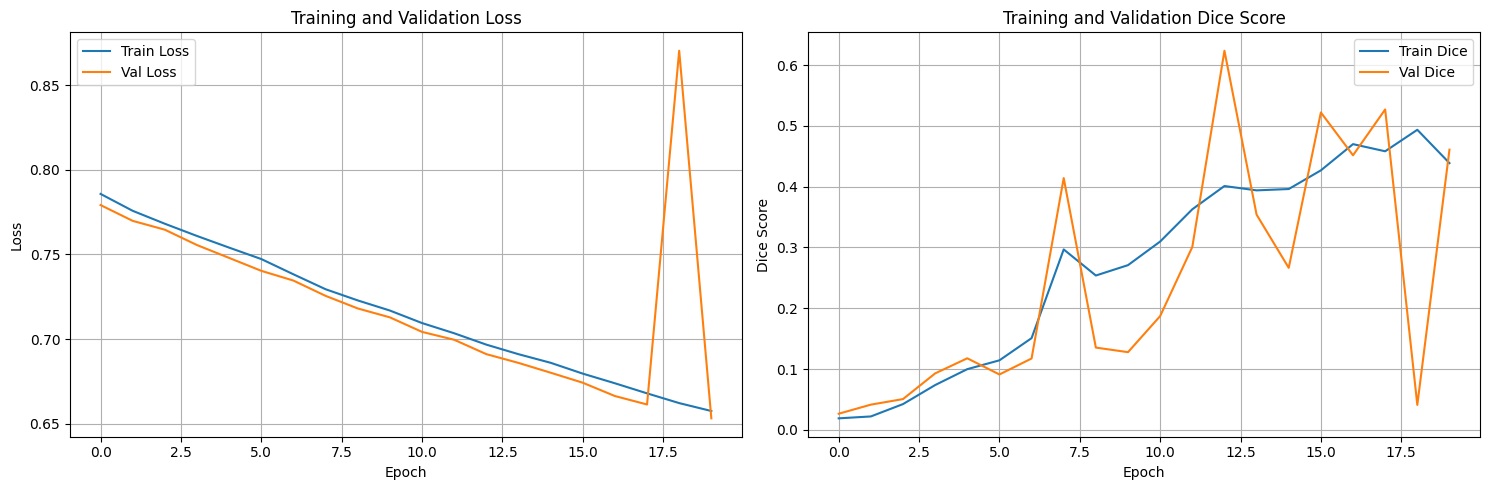

In [ ]:
print("\n3. Starting training...")
model, best_dice = train_model(
    model, train_loader, val_loader,
    num_epochs=20,
    learning_rate=1e-4
)

In [ ]:
print(f'\n\nTraining complete. Best Dice Score: {best_dice:.4f}')



Training complete. Best Dice Score: 0.6238


In [ ]:
# Visualize results
print("\n4. Generating visualizations...")
visualize_predictions_CM(model, val_loader, device, num_samples=len(train_dataset))


4. Generating visualizations...


NameError: name 'model' is not defined